# 1) What is the mechanism used by the Voting Classifier to aggregate predictions from multiple base models and their differences? Explain with suitable example. If predictions conflict among the base models, what strategies can be employed to resolve the conflicts and make more reliable final predictions in the Voting Classifier? 

# 2) Prove that Elastic net can be used as either LASSO or Ridge regulariser.

Elastic Net regularization is a linear combination of L1 and L2 regularization. Its objective function can be formulated as:

$$
J(\theta) = \mathrm{MSE}(\theta) + r \alpha \sum_{i=1}^{n} |\theta_i| + \frac{1-r}{2} \alpha \sum_{i=1}^{n} \theta_i^2
$$

Where:
- $ J(\theta) $ is the cost function.
- $\mathrm{MSE}(\theta)$ stands for the Mean Squared Error.
- $\alpha$ is the regularization strength, equivalent to $\lambda$ in some formulations.
- $r$ is the mixing parameter between the L1 (LASSO) and L2 (Ridge) penalties. $r$ lies in the range [0,1].
- $\theta$ represents the parameter vector, and the summation runs over all its components.

The two terms added to the MSE represent the L1 and L2 penalties:

1. $ r \alpha \sum_{i=1}^{n} |\theta_i| $ is the L1 penalty (LASSO). Elastic Net behaves as LASSO with a regularization strength of $\alpha$ when $r = 1$.
2. $ \frac{1-r}{2} \alpha \sum_{i=1}^{n} \theta_i^2 $ is the L2 penalty (Ridge). Elastic Net behaves as Ridge regression with a regularization strength of $\alpha$ when $r = 0$.

Based on the mixing parameter $r$:
- When $r = 1$, the Elastic Net objective becomes:

$$
J(\theta) = \mathrm{MSE}(\theta) + \alpha \sum_{i=1}^{n} |\theta_i|
$$

This is essentially the cost function for LASSO regression.

- When $r = 0$, the Elastic Net objective becomes:

$$
J(\theta) = \mathrm{MSE}(\theta) + \frac{1}{2} \alpha \sum_{i=1}^{n} \theta_i^2
$$

This corresponds to the cost function for Ridge regression.

Thus, by varying the parameter $r$, Elastic Net can be tailored to act as either LASSO (for $r = 1$) or Ridge (for $r = 0$) regularization.

Reference:
towards data science, (n.d.). 'Ridge, LASSO, and ElasticNet Regression'. Available at: https://towardsdatascience.com/ridge-lasso-and-elasticnet-regression-b1f9c00ea3a3 [Accessed on: 14 August 2023].



In [10]:
import numpy as np
#preparing our data
import pandas as pd
from sklearn.preprocessing import LabelBinarizer


training = pd.read_csv("aps_failure_training_set.csv",  skiprows=20)
test = pd.read_csv("aps_failure_test_set.csv", skiprows=20)
binarizer = LabelBinarizer()

#prepare class:
training["class"] = training["class"].map({'neg':0, 'pos':1})
test["class"] = test["class"].map({'neg':0, 'pos':1})
 
 #Replace na by the means of the column.
training = training.replace('na',np.nan)
test = test.replace('na',np.nan)

# Convert the dataframe to float dtype, so that np.nan can be used
training = training.astype(float)
test = test.astype(float)

# Replace np.nan with the rounded mean of the respective columns
training = training.fillna(round(training.mean()))
test = test.fillna(round(test.mean()))

# Convert the dataframe back to integer dtype
training = training.astype(int)
test = test.astype(int)

#Data should be OK.


# 3) Analyse the importance of the features for predicting “class” using two different approaches. Explain the similarity/difference between outcomes.

/Users/marsson/anaconda3/envs/m1/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


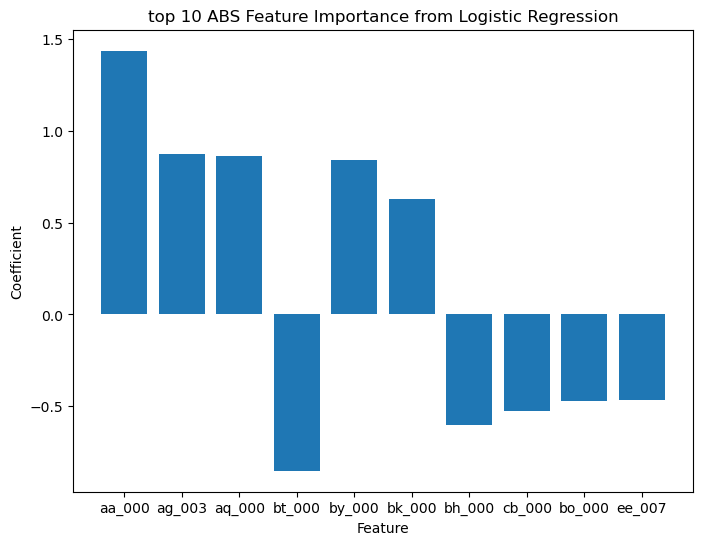

In [16]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

#Using Linear regression:
X_lin = training.drop(columns={"class"},axis=1)
Y_lin = training["class"]

# Standardize features
scaler = StandardScaler()
X_lin_std = scaler.fit_transform(X_lin)

# Train a logistic regression model
model = LogisticRegression()
model.fit(X_lin_std, Y_lin)

# Get feature names and coefficients
feature_names = X_lin.columns
coefficients = model.coef_[0]

# Create a dataframe for features and their corresponding coefficients
coeff_df_lin = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})
# Sort dataframe by absolute coefficient values in descending order

coeff_df_lin = coeff_df_lin.reindex(coeff_df_lin.Coefficient.abs().sort_values(ascending=False).index)
coeff_df_lin = coeff_df_lin.iloc[:10]
# Visualize the coefficients
plt.figure(figsize=(8, 6))
plt.bar(coeff_df_lin['Feature'], coeff_df_lin['Coefficient'])
plt.xlabel('Feature')
plt.ylabel('Coefficient')
plt.title('top 10 ABS Feature Importance from Logistic Regression')
plt.show()

[ 8.52399472e-07 -0.00000000e+00  1.71876666e-12 -2.41604955e-12
 -0.00000000e+00 -0.00000000e+00 -2.94193693e-08 -2.31637986e-07
 -1.12048926e-07  3.94308463e-08 -1.70812903e-09 -7.29785092e-09
 -2.22438490e-09 -5.12935178e-10 -2.07915641e-08  3.46132926e-10
 -3.72400327e-09 -5.58754969e-09 -9.68584297e-08  3.48504287e-08
 -3.31316099e-09  1.48665108e-08  9.31722520e-09 -8.37173622e-09
 -3.91163856e-09  5.37333591e-08  0.00000000e+00 -8.19377182e-08
  2.20268035e-08  3.07160745e-07  1.02132360e-06 -2.50953425e-06
  3.90579383e-09 -2.81416897e-09 -4.02710936e-09  2.91081581e-08
 -1.72819828e-09  8.07083444e-10 -7.84897878e-09 -7.22609838e-09
 -1.10854401e-09  7.78436309e-08 -8.16129378e-08  2.69583063e-07
 -6.51819698e-08  1.07920985e-08  8.81199006e-10  4.10017556e-10
 -2.43669400e-09  3.19599803e-08 -1.78018824e-07  5.15033328e-07
  7.19756187e-10 -1.97370444e-10  6.73191205e-09 -4.34124810e-08
  5.98022914e-08 -7.05447572e-09 -6.55871619e-09 -7.30651711e-09
  1.09624691e-08  2.45323

/Users/marsson/anaconda3/envs/m1/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.247e+02, tolerance: 9.833e-02
  model = cd_fast.enet_coordinate_descent(


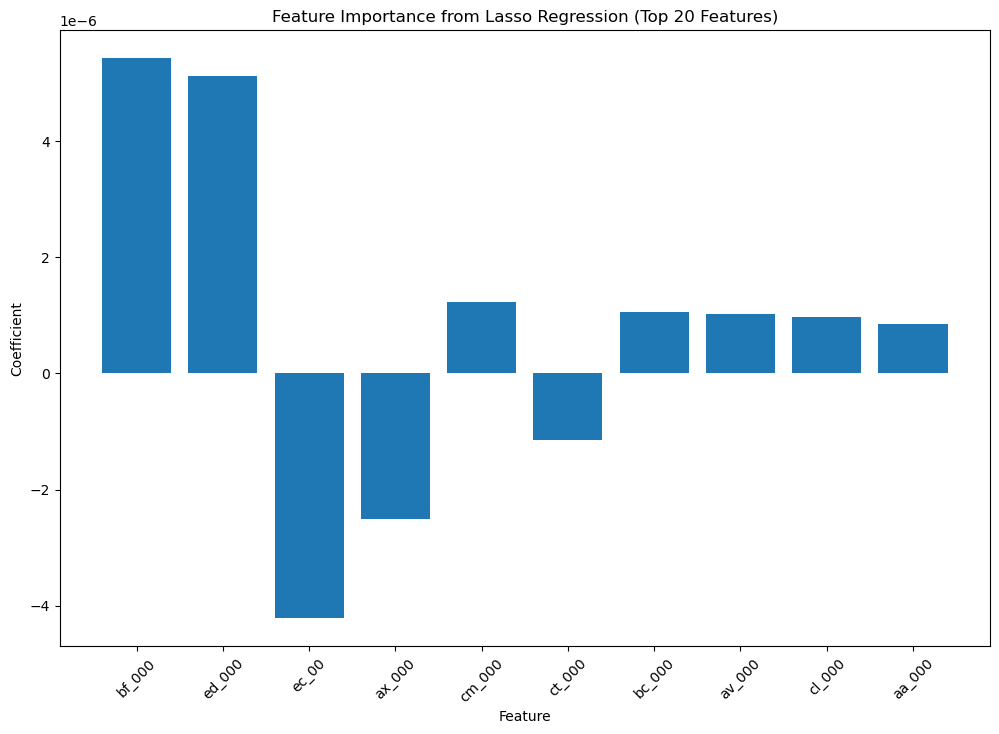

In [26]:
from sklearn.linear_model import Lasso

#Same using Lasso
X_lass = training.drop(columns={"class"},axis=1)
Y_lass = training["class"]

# Train a Lasso regression model
model = Lasso(alpha=0.5)
model.fit(X_lass, Y_lass)

# Get feature names and coefficients
feature_names = X_lass.columns
coefficients = model.coef_
print(coefficients)
# Create a dataframe for features and their corresponding coefficients
coeff_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})

# Filter out features with zero coefficients
non_zero_coeff = coeff_df[coeff_df['Coefficient'] != 0]

# Sort dataframe by absolute coefficient values in descending order
non_zero_coeff = non_zero_coeff.reindex(non_zero_coeff.Coefficient.abs().sort_values(ascending=False).index)

# Get the first 10 features
top_features = non_zero_coeff.iloc[:10]

# Visualize the coefficients of the first10 features
plt.figure(figsize=(12, 8))
plt.bar(top_features['Feature'], top_features['Coefficient'])
plt.xlabel('Feature')
plt.ylabel('Coefficient')
plt.title('Feature Importance from Lasso Regression (Top 20 Features)')
plt.xticks(rotation=45)
plt.show()
